In [4]:

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Figures
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
import numpy as np
import itertools
from collections import defaultdict

# Introduction

This assignment focuses on applying the Feature Engineering processes and the Evaluation methods, learned in class, to solve a practical scenario: predict the employees' absenteeism at workplace.

In particular, we are going to use the experimental scenario proposed by the Absenteeism at work Data Set. This dataset includes several explanatory variables  (that may/may not relate to their absence from work) collected for 36 different employees. For more details on the dataset and the competition see 
<https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work>. 

To simplify things, I have slightly modified the dataset to include a new categorical variable `Absenteeism` that substitutes the original target variable `Absenteeism.time.in.hours`. This is a binomial feature setting whether individuals are going to be absent more than X (`X=5`) hours in total (i.e., if it's going to be a long absence).
In addition, to allow the fair comparison of your results, I have split the dataset into training and test. For the test I have removed the target variable `Absenteeism` - to do the predictions, using the final model. These are the two CSV file provided for this assignment.

The objective of this task is to make sense of the data, analyze the correlations between the features to select the best subset and finally train the predictive model. 

Tthe first step is to visualize and analyze the dataset in order to understand the information that we have. Then, clean the dataset to solve the problems it might present.

Once we have the dataset cleaned, we can start the feature engineering process itself to select the most representative feature set to feed the classification models. Previously to this step, I will create new features or modify the ones already in the dataset.

## The Goal
The main goal is to **predict whether or not an individual is going to have a long absence** (`Absenteeism` variable). It's therefore a binary classification problem.

To that end, different steps must be covered:

- Clean the dataset to allow its further processing. The dataset should be transformed by removing errors, imputing missing values (if present in the dataset) and leaving only those features that are really informative. At this point, it's important to run a basic model (baseline) over the dataset to have an starting point for further processing.
- Use the feature engineering techniques explained in class to construct new features and select the best subset of them: filtering, wrapper and embedded methods. Check if you have improved your model w.r.t. your baseline model.
- Properly apply the evaluation methods and ideas (train, validation, test splitting; cross-validation, choose the proper metric, ..) to understand the real performance of the proposed models, making sure that they will generalize to unseen data (test set). I will use accuracy for evaluate your results, so I recommend you to use the same metric to train your models.

These steps are iterative. One must show, with data, whether the decisions are working towards a better model or not, to finally make a recommendation on what are the best features and the best model. (Kind of representing HR within a company).

# Useful Functions

In order to facilitate the evaluation of the impact of the different steps, I am going to place the code for creating a baseline model in a function. Now I can call it again and again without having to re-write everything. The only thing that changes from one case to another is the dataset that is used to train the model.


In [5]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes.tolist(), rotation=45)
    plt.yticks(tick_marks, classes.tolist())
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def train_model(X,y, model, show_figures=True): 
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_mat = confusion_matrix(y, y_pred)
    score = accuracy_score(y,y_pred)
    print("Accuracy = {0:.4f}".format(score))
    if show_figures:
        plot_confusion_matrix(conf_mat, y.unique())
        model.fit(X, y)
        get_feature_importance(model, X.columns, n_features=25)
    return model, score

def get_feature_importance(clf, features, n_features):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[:n_features]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,10))
    featfig.suptitle(str(n_features) + " Most important features")
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(features)[sorted_idx], fontsize=15)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)
    plt.show()

# Data Reading and preparation

The dataset is offered in two separated fields, one for the training and another one for the test set. 

In [6]:
training = pd.read_csv("Absenteeism_at_work_classification_training.csv", delimiter=";", decimal=".")
test = pd.read_csv("Absenteeism_at_work_classification_test.csv", delimiter=";", decimal=".")

To avoid applying the cleaning process two times (once for training and once for test), it's possible to join both datasets, apply the FE and then split the datasets again. However, if we try to join the two dataframes as they are, we will get an error as they do not have the same columns: `test` does not have a column for the target feature `Absenteeism`. Therefore, I'll first create this column in the test set and then we join the data.

In [7]:
test['Absenteeism'] = 0
dataset = training.append(test)

Let's now visualize the dataset to see where to begin.

In [8]:
pd.options.display.max_columns = dataset.shape[1] # It prints the info in all the columns

dataset.describe()

,ID,Reason.for.absence,Month.of.absence,Day.of.the.week,Seasons,Transportation.expense,Distance.from.Residence.to.Work,Service.time,Age,Work.load.Average.day,Hit.target,Disciplinary.failure,Education,Son,Social.drinker,Social.smoker,Pet,Weight,Height,Body.mass.index,ID.Worker,Absenteeism
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,370.500000,19.216216,6.324324,3.914865,2.544595,221.329730,29.631081,12.554054,36.450000,271.490235,94.587838,0.054054,1.291892,1.018919,0.567568,0.072973,0.745946,79.035135,172.114865,26.677027,18.017568,0.294595
std,213.763888,8.433406,3.436287,1.421675,1.111831,66.952223,14.836788,4.384873,6.478772,39.058116,3.779313,0.226277,0.673238,1.098489,0.495749,0.260268,1.318258,12.883211,6.034995,4.285452,11.021247,0.456169
min,1.000000,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205.917000,81.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,1.000000,0.000000
25%,185.750000,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244.387000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,9.000000,0.000000
50%,370.500000,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264.249000,95.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,18.000000,0.000000
75%,555.250000,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,294.217000,97.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,28.000000,1.000000
max,740.000000,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378.884000,100.000000,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,36.000000,1.000000


In [9]:
dataset.dtypes

ID                                   int64
Reason.for.absence                   int64
Month.of.absence                     int64
Day.of.the.week                      int64
Seasons                              int64
Transportation.expense               int64
Distance.from.Residence.to.Work      int64
Service.time                         int64
Age                                  int64
Work.load.Average.day              float64
Hit.target                           int64
Disciplinary.failure                 int64
Education                            int64
Son                                  int64
Social.drinker                       int64
Social.smoker                        int64
Pet                                  int64
Weight                               int64
Height                               int64
Body.mass.index                      int64
ID.Worker                            int64
Absenteeism                          int64
dtype: object

We can see a problem by just taking a look to the summary: there are some categorical columns codified as numeric (including the target feature `Absenteeism`). In addition, a deeper look to the data is performed to detect more subtle issues: correlation between features, skewness in the feature values...

# Data Cleaning

None of the features in the dataset present any NULL values so we don't have to take care of this aspect. This is extremely uncommon. The only reason these don't exist in this dataset is because it has been properly cleaned for research purposes.

Let's focus on re-coding the variables that are numerical and should be categorical.

In [10]:
categorical_columns = ['ID', 'ID.Worker','Reason.for.absence', 'Month.of.absence', 'Day.of.the.week', 'Seasons', 'Disciplinary.failure', 'Social.drinker', 'Social.smoker', 'Absenteeism']

dataset[categorical_columns] = dataset[categorical_columns].astype("category")
dataset.dtypes

ID                                 category
Reason.for.absence                 category
Month.of.absence                   category
Day.of.the.week                    category
Seasons                            category
Transportation.expense                int64
Distance.from.Residence.to.Work       int64
Service.time                          int64
Age                                   int64
Work.load.Average.day               float64
Hit.target                            int64
Disciplinary.failure               category
Education                             int64
Son                                   int64
Social.drinker                     category
Social.smoker                      category
Pet                                   int64
Weight                                int64
Height                                int64
Body.mass.index                       int64
ID.Worker                          category
Absenteeism                        category
dtype: object

To facilitate the understanding of the feature analysis, I am going to change the name of some of them to their actual meaning (this meaning is in the dataset description file).

In [11]:
reason_for_absence_dict={0:'Infectious parasitic diseases',
                         1:'Neoplasms',
                         2:'Diseases of the blood',
                         3:'Endocrine and metabolic diseases',
                         4:'Mental and behavioural disorders',
                         5:'Diseases of the nervous system',
                         6:'Diseases of the eye and adnexa',
                         7:'Diseases of the ear and mastoid process',
                         8:'Diseases of the circulatory system',
                         9:'Diseases of the respiratory system',
                         10:'Diseases of the digestive system',
                         11:'Diseases of the skin and subcutaneous tissue',
                         12:'Diseases of the musculoskeletal system and connective tissue', 
                         13:'Diseases of the genitourinary system',
                         14:'Pregnancy, childbirth and the puerperium',
                         15:'Certain conditions originating in the perinatal',
                         16:'Congenital malformations, deformations and chromosomal abnormalities',
                         17:'Symptoms, signs and abnormal clinical  findings',
                         18:'Injury, poisoning and certain other consequences of external causes',
                         19:'causes of morbidity and mortality',
                         21:'Factors influencing health status and contact with health services',
                         22:'patient follow-up',
                         23:'medical consultation',
                         24:'blood donation',
                         25:'laboratory examination',
                         26:'unjustified absence',
                         27:'physiotherapy',
                         28:'dental consultation'}

dataset['Reason.for.absence'] = dataset['Reason.for.absence'].replace(reason_for_absence_dict).astype('category')

dataset.Seasons = dataset.Seasons.replace({1:'summer',2:'autumn',3:'winter',4:'spring'}).astype('category')

dataset.Education = dataset.Education.replace({1:'highschool',2:'graduate',3:'postgraduate',4:'master&PhD'}).astype('category')

In [12]:
dataset.dtypes

ID                                 category
Reason.for.absence                 category
Month.of.absence                   category
Day.of.the.week                    category
Seasons                            category
Transportation.expense                int64
Distance.from.Residence.to.Work       int64
Service.time                          int64
Age                                   int64
Work.load.Average.day               float64
Hit.target                            int64
Disciplinary.failure               category
Education                          category
Son                                   int64
Social.drinker                     category
Social.smoker                      category
Pet                                   int64
Weight                                int64
Height                                int64
Body.mass.index                       int64
ID.Worker                          category
Absenteeism                        category
dtype: object

It's now formatted as it should. Let's start working with it. In order to have a baseline to compare the improvements introduced by the feature engineering process I am going to train a model with the dataset as it is.

Finally, since we have numerical and categorical values, we have to dummify the categorical features in the dataset so we can train our ML models. I will also standardize the numerical values

In [14]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

categorical_cols = dataset.columns[dataset.dtypes=='category'].tolist()
categorical_cols.remove('Absenteeism') # Remove the target variable

# I do not want to include the ID or the ID of the worker
categorical_cols.remove('ID') 
categorical_cols.remove('ID.Worker')
numerical_cols = dataset.columns[dataset.dtypes!='category'].tolist()

ohe = OneHotEncoder()
std_scaler = StandardScaler()
mms = MinMaxScaler()

# Concat the numerical and dummified categorical columns
dummified_dataset = pd.concat([pd.DataFrame(mms.fit_transform(std_scaler.fit_transform(dataset[numerical_cols])), columns=numerical_cols).reset_index(drop=True),                    
                               pd.DataFrame(ohe.fit_transform(dataset[categorical_cols]).toarray(), columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True),
                               dataset['Absenteeism'].reset_index(drop=True)], axis=1)

Accuracy = 0.8078


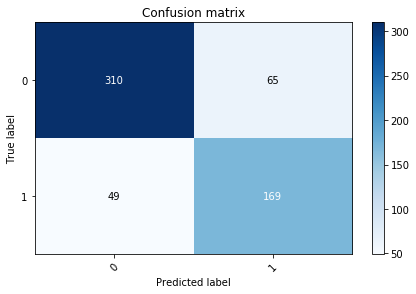

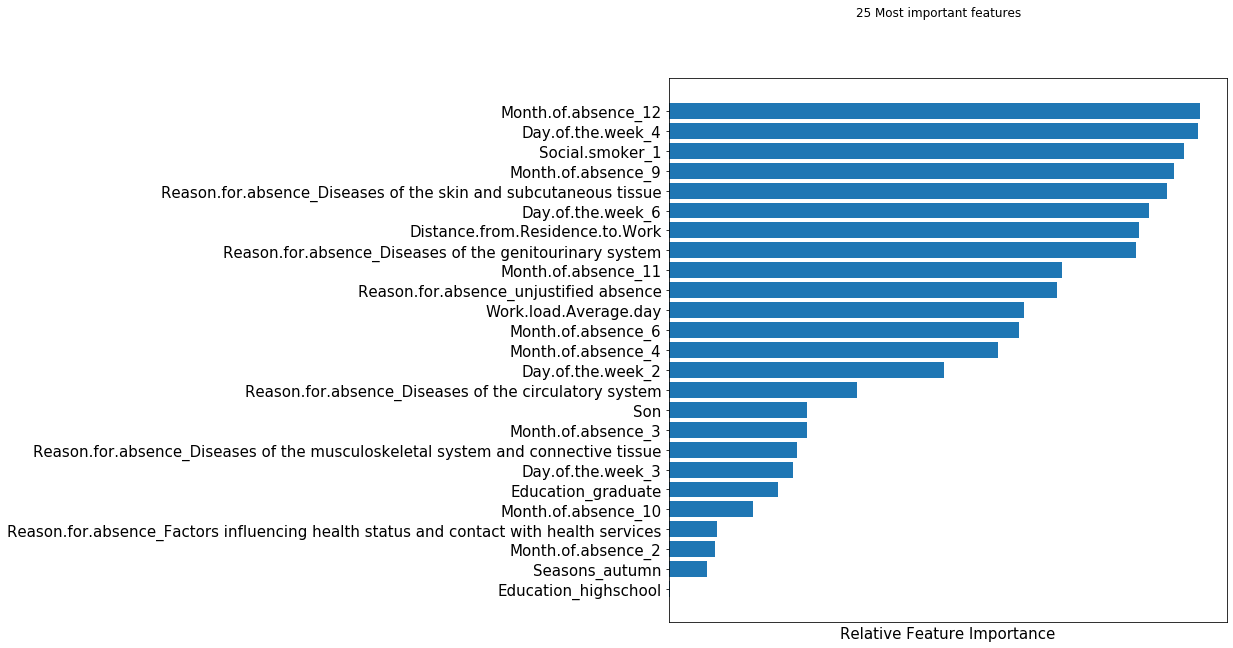

In [16]:
baseline_model, score = train_model(dummified_dataset.iloc[0:593].drop(['Absenteeism'],axis=1), dummified_dataset.iloc[0:593]['Absenteeism'], linear_model.LogisticRegression(max_iter=10000, solver="lbfgs", penalty='none'))

In [17]:
results_df = pd.DataFrame(columns=['Approach', 'Accuracy'])
results_df.loc[len(results_df)] = ['LR Baseline', score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757


Accuracy around 81%. Now I'll try to improve it. To that end, we can study the  most important features in this baseline model. This will give us a first idea on the most important aspects in order to predict the `Absenteeism`.


We can see, by analyzing the most important features, that `Reason.for.absence` is the most important feature to predict the time of the absence. It's obvious, an absence caused by a serious illness is expected to lead to a longer absence over time.


## Outliers

I will now focus on numerical values. If NULL values are the natural enemy of categorical values, the main problem with numerical values are outliers (values which largely differ from the rest). Outliers can mislead the training of our models resulting in less accurate models and ultimately worse results.

In this section I intend to identify outliers, dealing with them in a rational manner. Summarizing the dataset, we can see variables where "Max." has more impact than other values. These features are susceptible of containing outliers. Nevertheless, the easiest way to detect outliers is visualizing the numerical values; for instance, by `boxploting` the column values.

Analyzing outliers of column: Transportation.expense
0 outliers removed


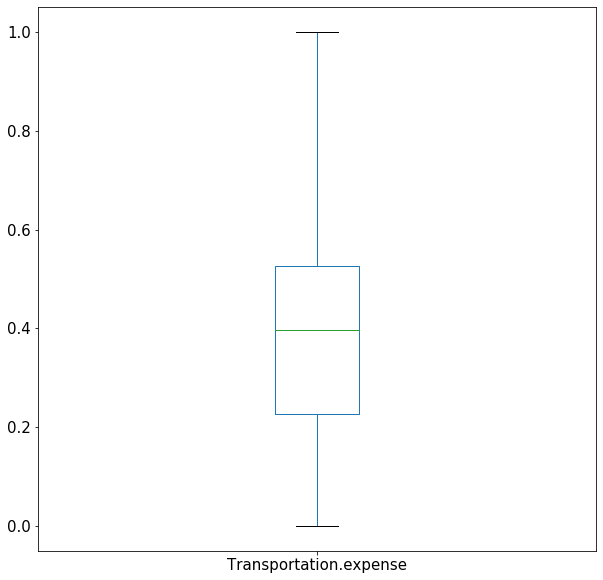

Analyzing outliers of column: Distance.from.Residence.to.Work
0 outliers removed


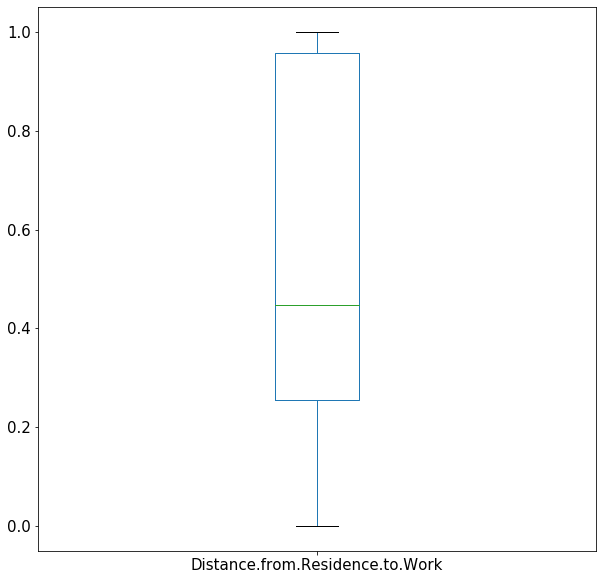

Analyzing outliers of column: Service.time
0 outliers removed


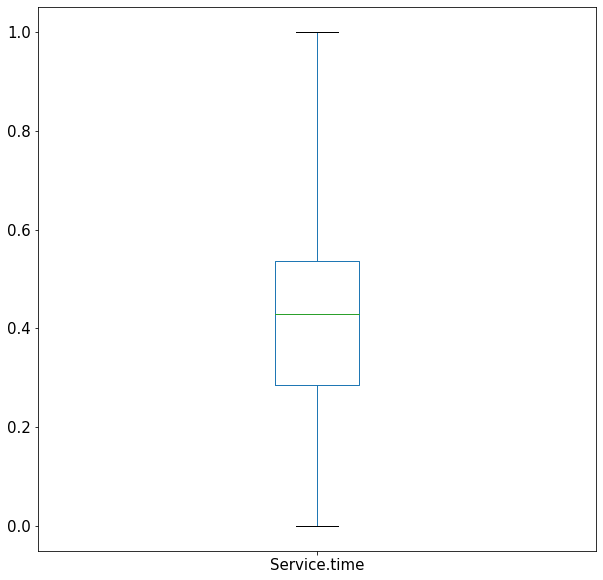

Analyzing outliers of column: Age
0 outliers removed


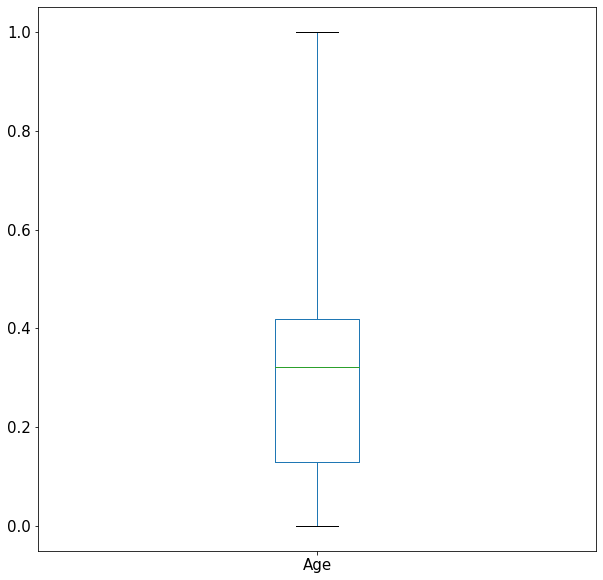

Analyzing outliers of column: Work.load.Average.day
0 outliers removed


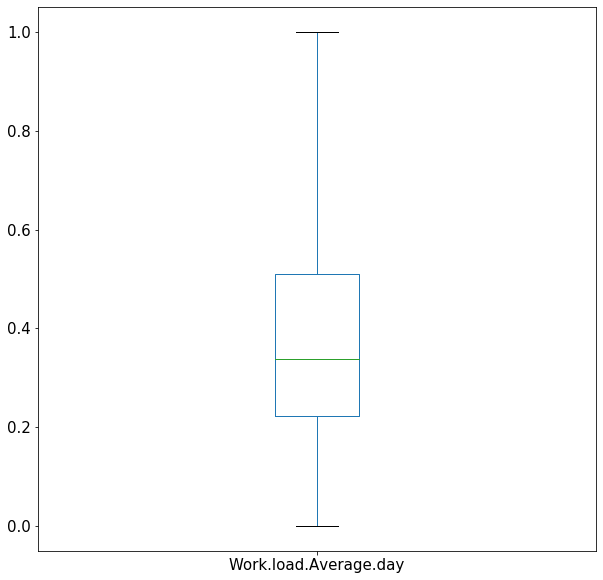

Analyzing outliers of column: Hit.target
0 outliers removed


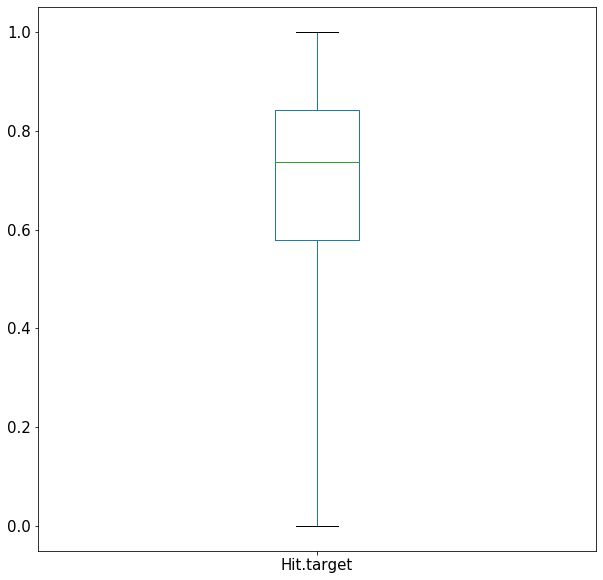

Analyzing outliers of column: Son
0 outliers removed


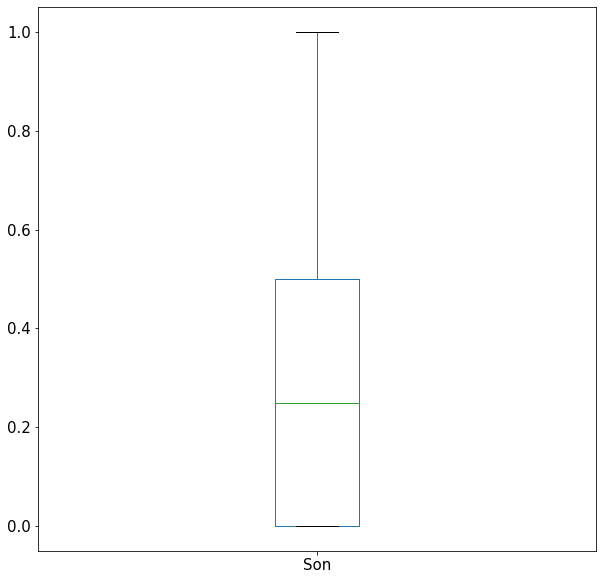

Analyzing outliers of column: Pet
32 outliers removed


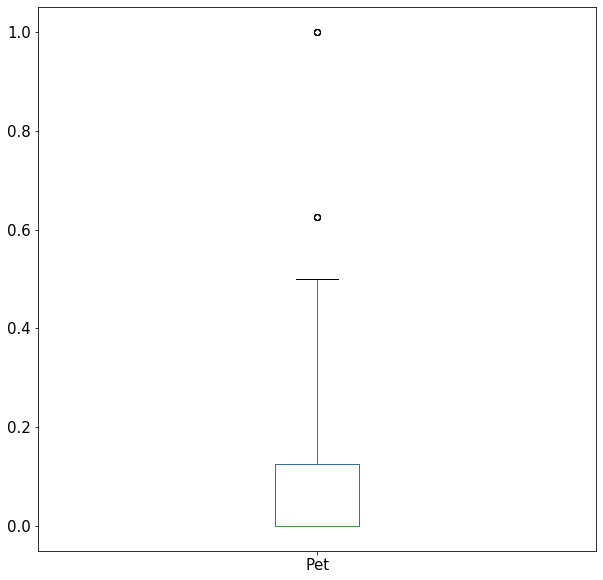

Analyzing outliers of column: Weight
0 outliers removed


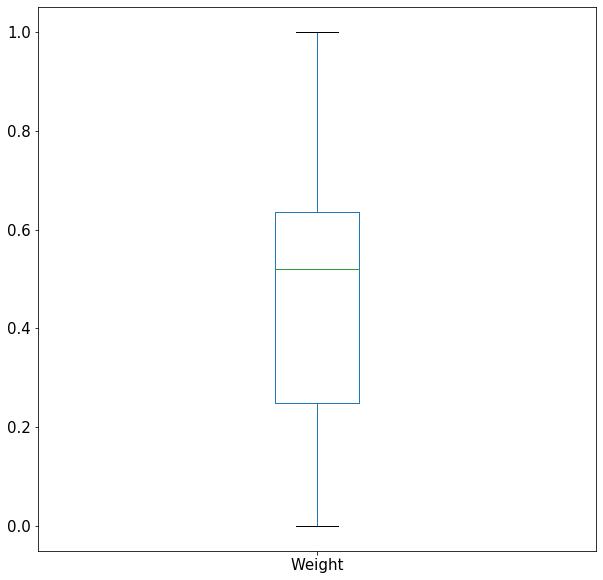

Analyzing outliers of column: Height
42 outliers removed


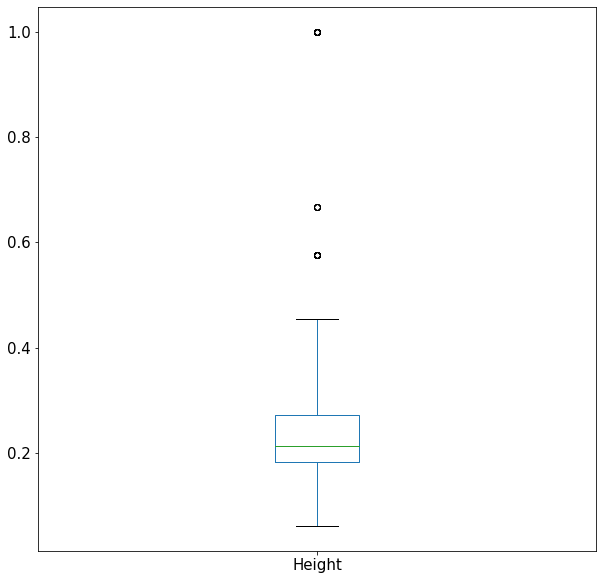

Analyzing outliers of column: Body.mass.index
0 outliers removed


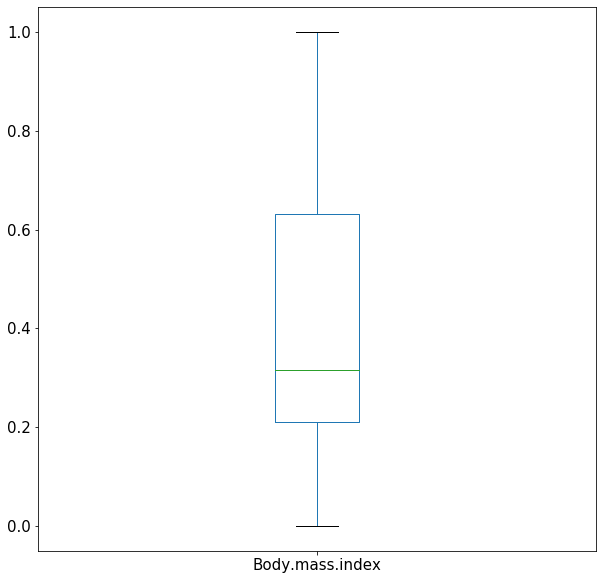

In [18]:
def remove_outlier(df_in, col_name, coef):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-coef*iqr
    fence_high = q3+coef*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed".format(len(df_in)-len(df_out)))
    return df_out

outlier_free_dataset = dummified_dataset.iloc[0:593].copy(deep=True) # Only the training data

for (columnName, _) in outlier_free_dataset.iteritems():
    if columnName in numerical_cols: # IS numeric
        print("Analyzing outliers of column: {}".format(columnName))
        plt.figure(figsize=(10,10))
        outlier_free_dataset.boxplot([columnName], grid=False, fontsize=15, whis=3)
        outlier_free_dataset = remove_outlier(outlier_free_dataset,columnName, 3)
        plt.show()

Accuracy = 0.8073


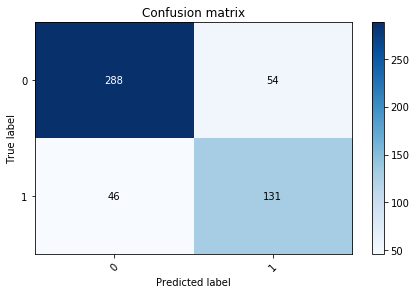

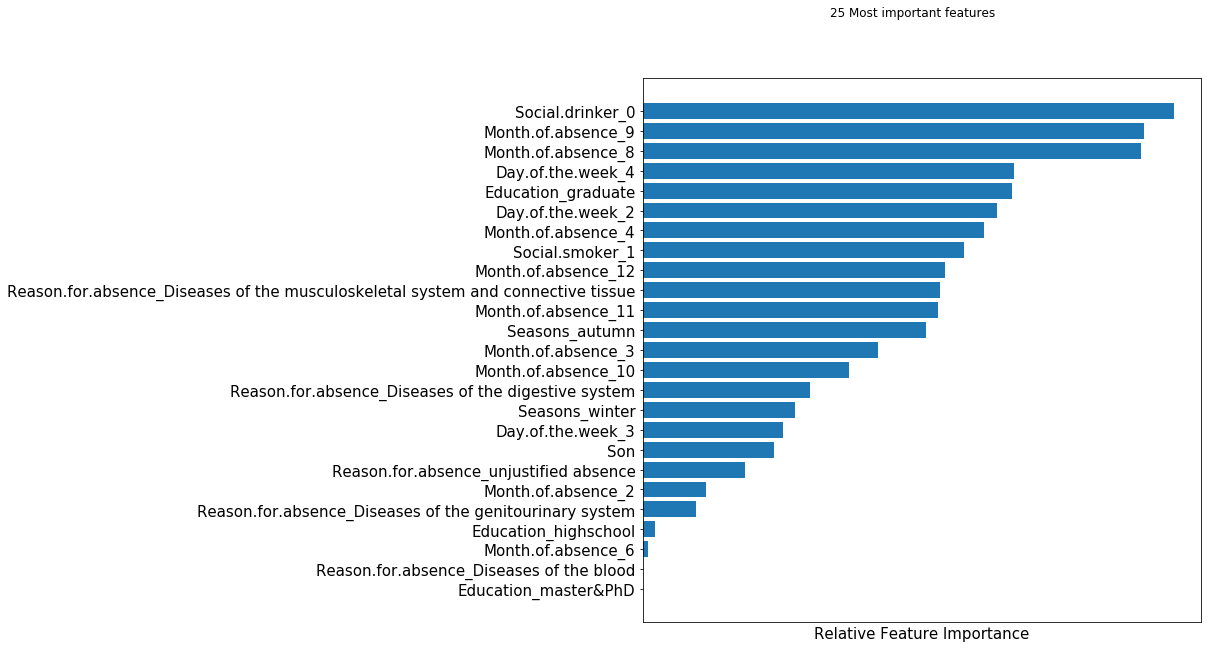

In [19]:
outlier_free_model, score = train_model(outlier_free_dataset.drop(['Absenteeism'], axis=1), outlier_free_dataset['Absenteeism'], linear_model.LogisticRegression(max_iter=10000, solver="lbfgs", penalty='none'))

In [20]:
results_df.loc[len(results_df)] = ['LR without outliers', score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,LR without outliers,0.807322


There's no real difference in the results and, given that the outliers are not that many, I have decided to keep them all.

## Correlated Features

I will now check whether there are correlated features, thus deciding what to do with them.

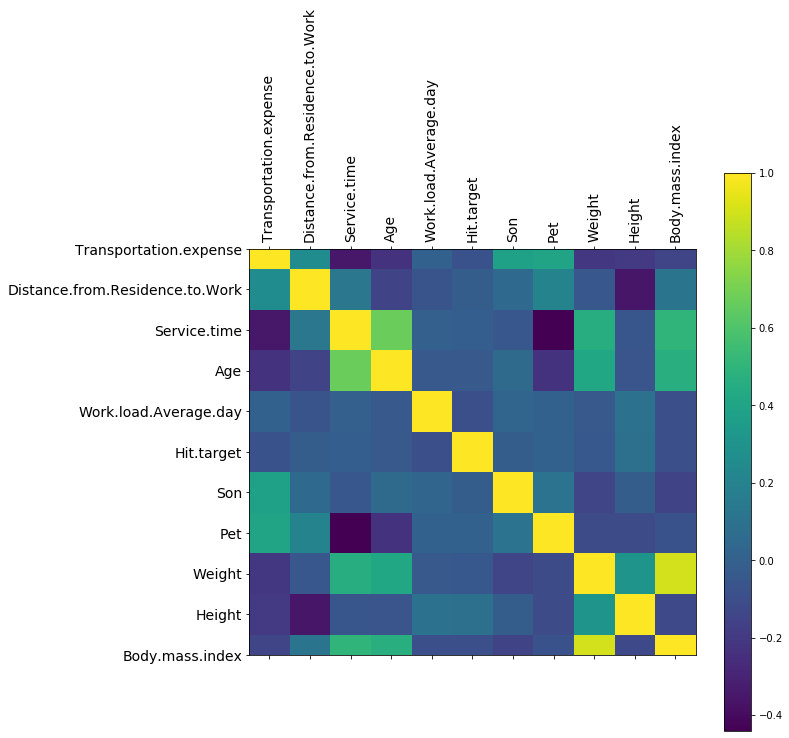

In [21]:
plt.figure(figsize=(10, 10))
plt.matshow(dummified_dataset[numerical_cols].corr(), fignum=1)
plt.xticks(range(dummified_dataset[numerical_cols].shape[1]), numerical_cols, fontsize=14, rotation=90)
plt.yticks(range(dummified_dataset[numerical_cols].shape[1]), numerical_cols, fontsize=14)
plt.colorbar()
plt.show()

There are some relevant relationships in the correlation matrix - some that are obvious, some that are more subtle. The main correlation stands between Body Mass Index and Weight. Nothing surprising here, the BMI is mainly computed as a function of the Weight. The question is now: Do we remove Weight or Body.mass.index? 

Accuracy = 0.8078


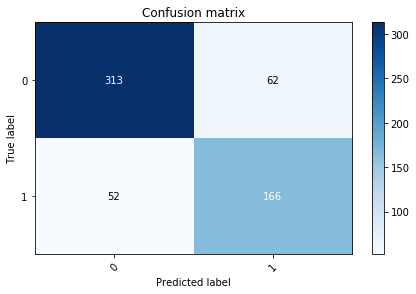

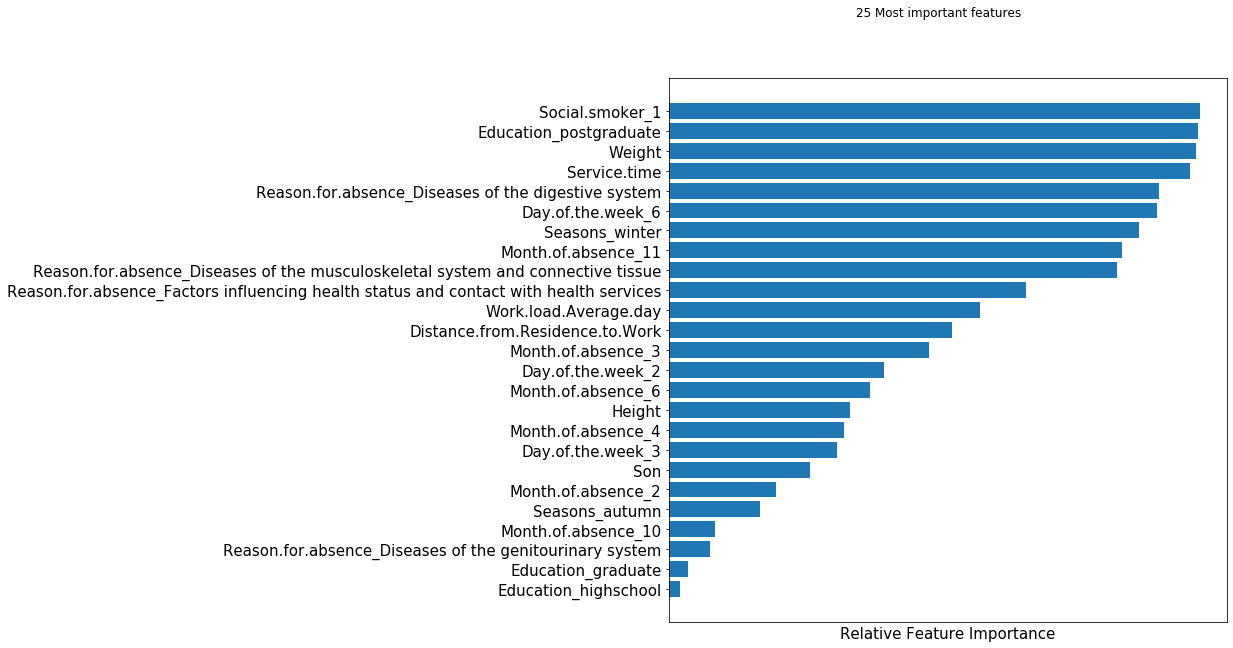

In [22]:
no_bmi_model, score = train_model(dummified_dataset.iloc[0:593].drop(['Body.mass.index','Absenteeism'], axis=1), dummified_dataset.iloc[0:593]['Absenteeism'], linear_model.LogisticRegression(max_iter=10000, solver="lbfgs", penalty='none'))

In [23]:
results_df.loc[len(results_df)] = ['LR without BMI', score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,LR without outliers,0.807322
2,LR without BMI,0.807757


Accuracy = 0.8094


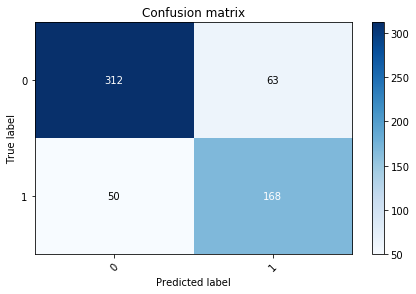

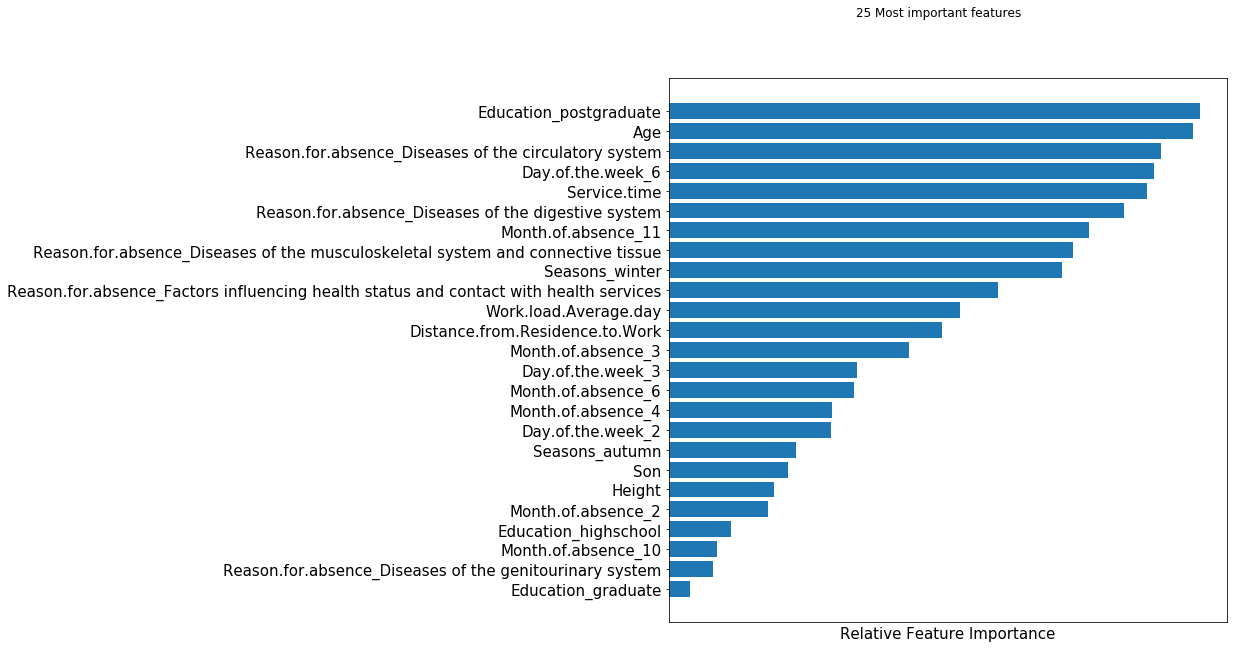

In [24]:
no_weight_model, score = train_model(dummified_dataset.iloc[0:593].drop(['Weight','Absenteeism'], axis=1), dummified_dataset.iloc[0:593]['Absenteeism'], linear_model.LogisticRegression(max_iter=10000, solver="lbfgs", penalty='none'))

In [25]:
results_df.loc[len(results_df)] = ['LR without weight', score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,LR without outliers,0.807322
2,LR without BMI,0.807757
3,LR without weight,0.809444


It seems that BMI better codifies the info, so I will keep it.


In the correlation matrix there is other correlation between `Service.time` and `Age`. If one individual spends more time in the company, usually he's getting older. If I have to remove one of them, I will choose Age. I think Service time is more important since the amount of time you spend in a company seems to be a good feature to predict whether you are staying, or not. Age cannot properly codify this issue: a 35-year-old employee could have been in the company for 10 years and a 42-year-old employee could have been in the company for just 1 month. I expect somebody that has stayed 10 years in the company to stay, or at least to be more likely to stay, when comparing someone in their first month.

Age could codify another aspect: young people are more likely to leave a company, than older people (that require more stability in their lives). Let's compare the models removing each one.

Accuracy = 0.8162


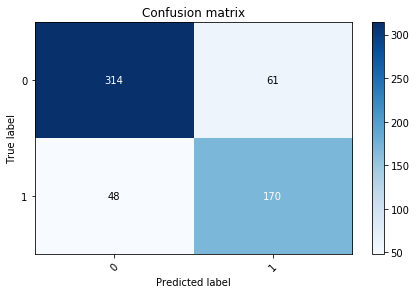

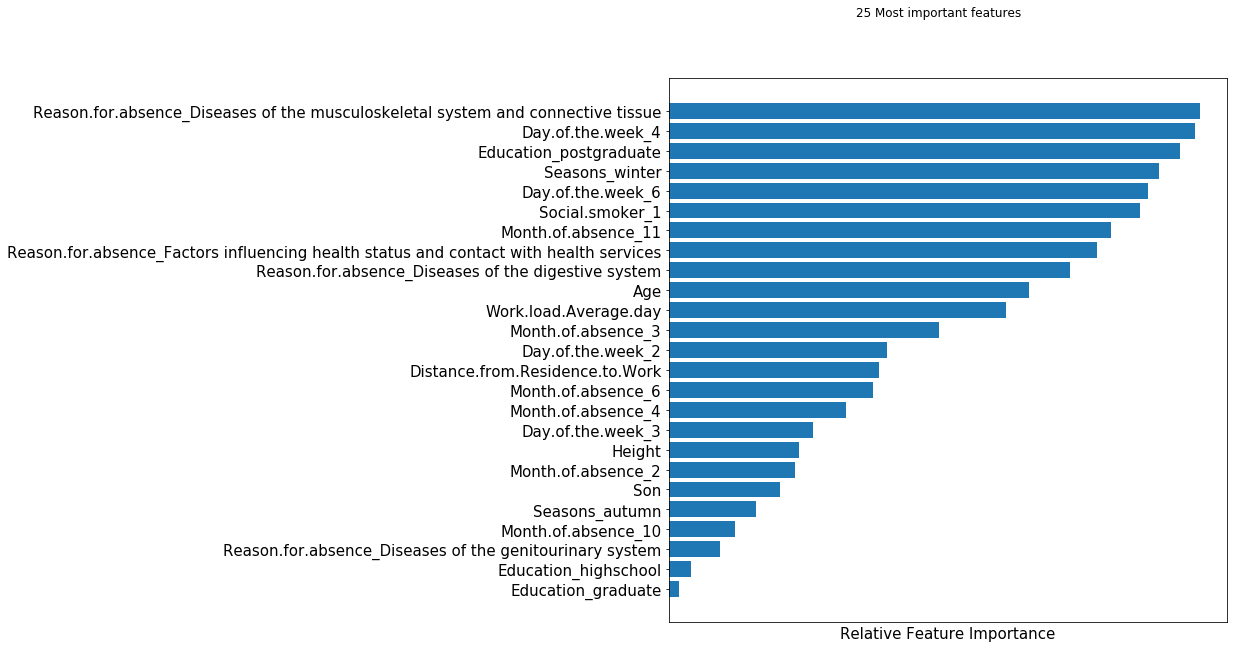

In [26]:
no_weight_service_time_model, score = train_model(dummified_dataset.iloc[0:593].drop(['Weight','Service.time','Absenteeism'], axis=1), dummified_dataset.iloc[0:593]['Absenteeism'],linear_model.LogisticRegression(max_iter=10000, solver="lbfgs", penalty='none'))

In [27]:
results_df.loc[len(results_df)] = ['LR without Weight and Service Time', score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,LR without outliers,0.807322
2,LR without BMI,0.807757
3,LR without weight,0.809444
4,LR without Weight and Service Time,0.816189


Accuracy = 0.8111


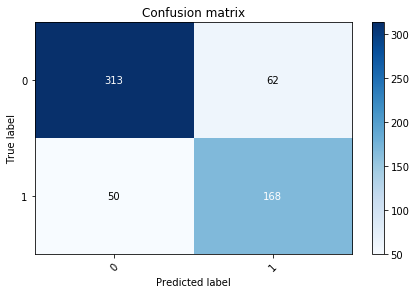

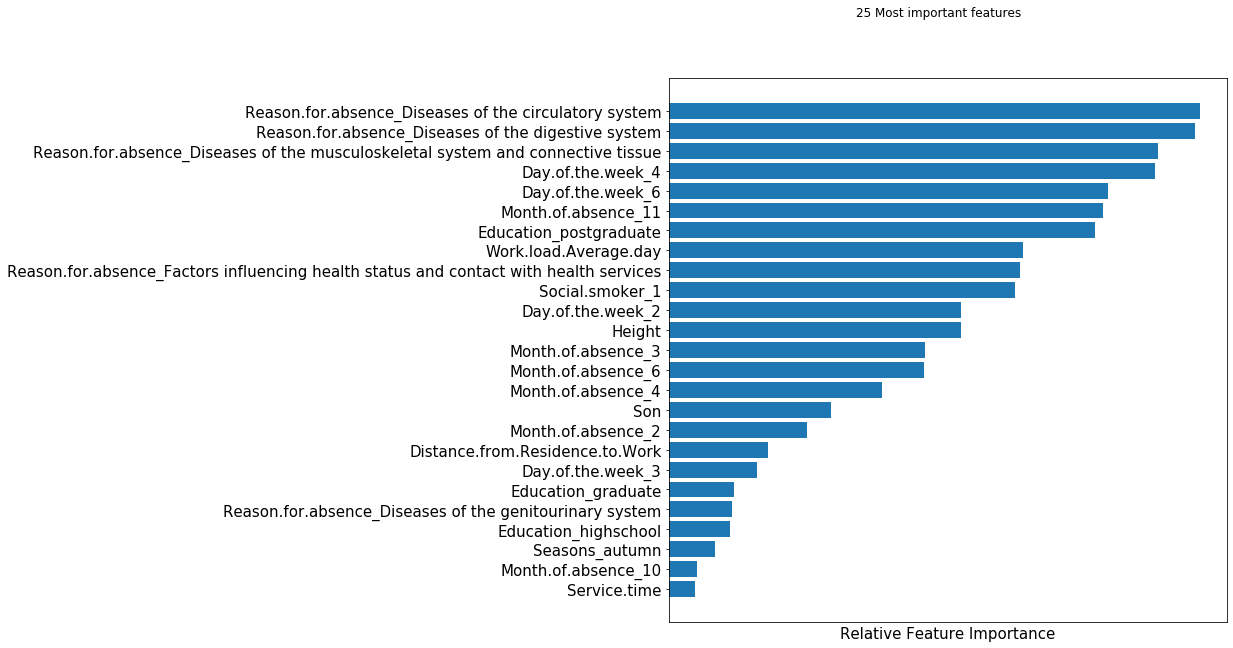

In [28]:
no_weight_age_model, score = train_model(dummified_dataset.iloc[0:593].drop(['Weight','Age','Absenteeism'], axis=1), dummified_dataset.iloc[0:593]['Absenteeism'],linear_model.LogisticRegression(max_iter=10000, solver="lbfgs", penalty='none'))

In [29]:
results_df.loc[len(results_df)] = ['LR without Weight and Age', score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,LR without outliers,0.807322
2,LR without BMI,0.807757
3,LR without weight,0.809444
4,LR without Weight and Service Time,0.816189
5,LR without Weight and Age,0.811130


It seems that there are some important trends related to the Age (more important than those related to the Service Time).

I will use this filtered dataset for the following steps. 

In [30]:
cleaned_dataset = dummified_dataset.drop(['Weight','Service.time'], axis=1)

# Feature Engineering

## Feature Creation

This section includes some ideas to extend the dataset with more features.

Let's start by considering what I think is one of the most important reasons for absence: having children. As one may imagine (or know if you have children), is that it could be a pontential source of absences. In the dataset we have this information in the feature `Son`, a numerical value with the number of children. However, I am thinking about a simpler feature, capturing the fact of whether you have children or not. The difference between no children and one child seems more relevant than between 1 and 2 children.

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Accuracy = 0.8162


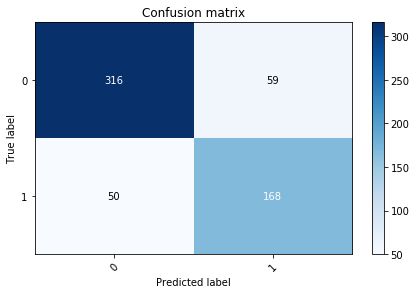

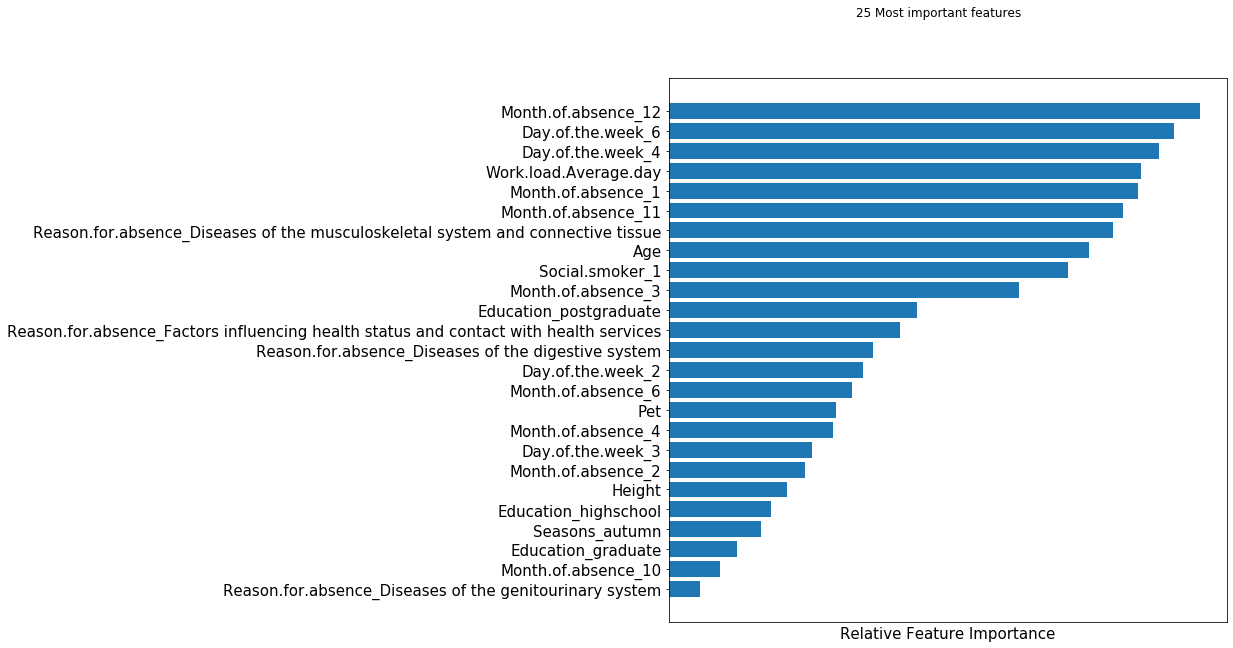

In [32]:
fe_dataset = cleaned_dataset.copy(deep=True) # In case I need the original one

# Binary feature (has or does not have a son).
fe_dataset['Has Son'] = 0
fe_dataset['Has Son'][fe_dataset['Son']!=0] = 1

fe_1_model, score = train_model(fe_dataset.iloc[0:593].drop(['Absenteeism'],axis=1), fe_dataset.iloc[0:593]['Absenteeism'], linear_model.LogisticRegression(max_iter=10000, solver="lbfgs", penalty='none'))

In [33]:
results_df.loc[len(results_df)] = ['LR Feature Engineering 1', score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,LR without outliers,0.807322
2,LR without BMI,0.807757
3,LR without weight,0.809444
4,LR without Weight and Service Time,0.816189
5,LR without Weight and Age,0.811130
6,LR Feature Engineering 1,0.816189


No improvement in accuracy. Let's try to remove the original feature `Son` since its information is already codified in the new feature.


Accuracy = 0.8212


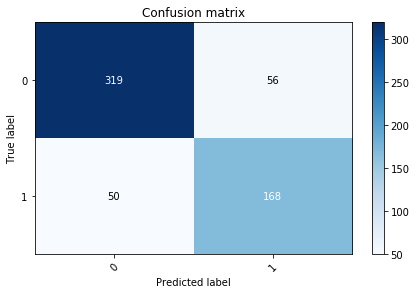

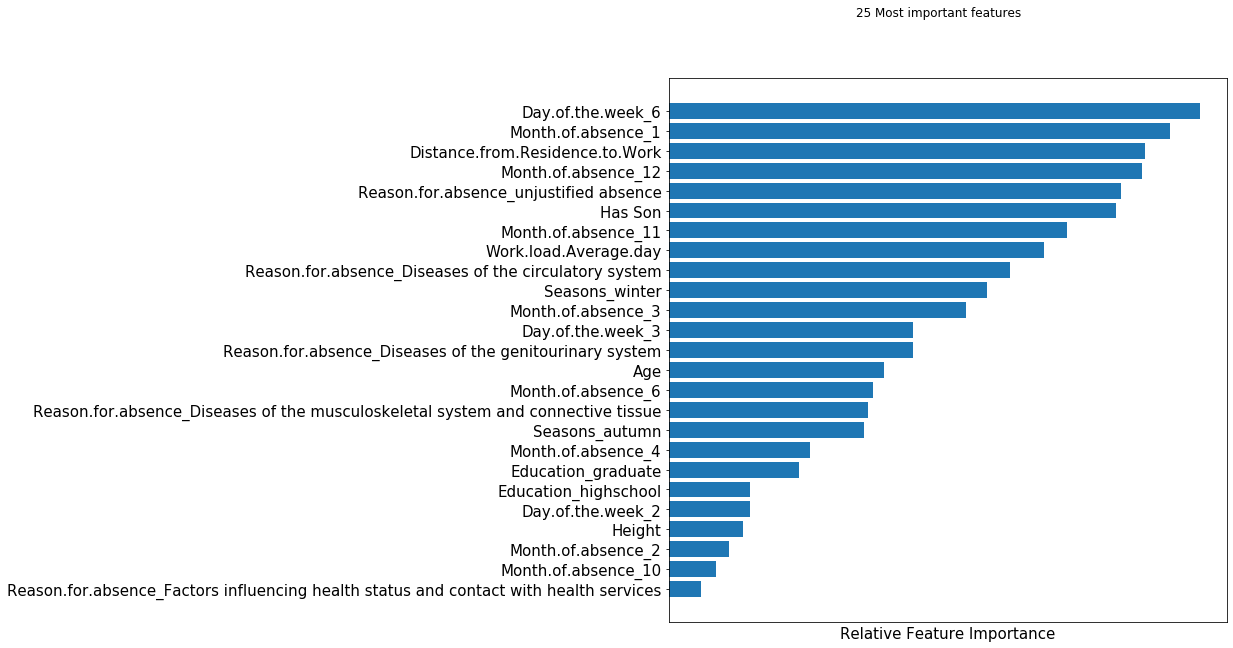

In [34]:
fe_2_model, score = train_model(fe_dataset.iloc[0:593].drop(['Son','Absenteeism'],axis=1), fe_dataset.iloc[0:593]['Absenteeism'], linear_model.LogisticRegression(max_iter=10000, solver="lbfgs", penalty='none'))

In [35]:
results_df.loc[len(results_df)] = ['LR Feature Engineering 2', score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,LR without outliers,0.807322
2,LR without BMI,0.807757
3,LR without weight,0.809444
4,LR without Weight and Service Time,0.816189
5,LR without Weight and Age,0.811130
6,LR Feature Engineering 1,0.816189
7,LR Feature Engineering 2,0.821248


As I was expecting this new binary feature is improving our model. Another aspect related to children that we could try (in addition to the number of children you have) is their age. It's true that children lead to absences, but specially when they are newborns. We do not have this information in our dataset so it's hard to conclude anything.

In [36]:
fe_dataset = fe_dataset.drop(['Son'], axis=1)

The same rationale can be applied to pets. The fact of having a pet or not can have an impact of the absences (they also get sick or require special care).


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy = 0.8094


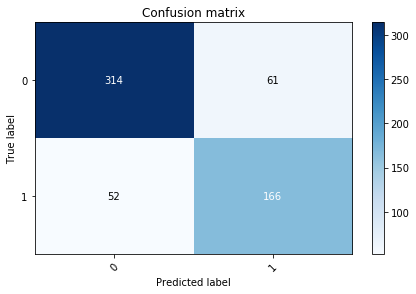

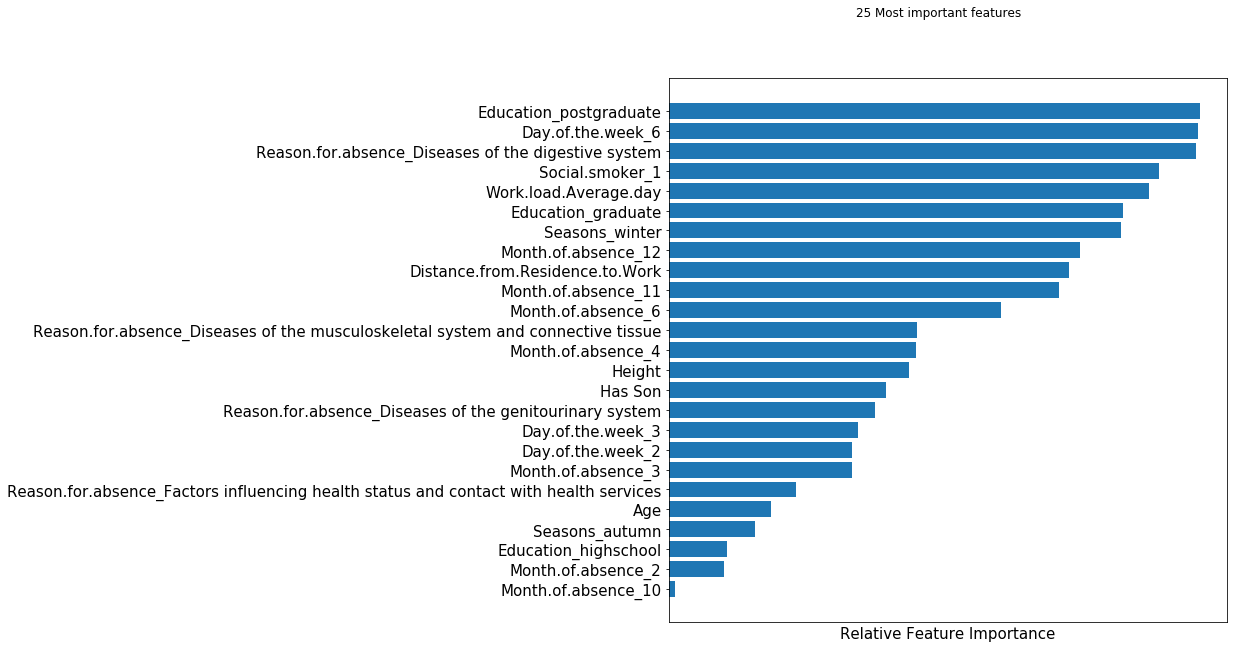

In [37]:
# Binary feature (has or does not have a son).
fe_dataset['Has Pet'] = 0
fe_dataset['Has Pet'][fe_dataset['Pet']!=0] = 1

fe_3_model, score = train_model(fe_dataset.iloc[0:593].drop(['Absenteeism'],axis=1), fe_dataset.iloc[0:593]['Absenteeism'], linear_model.LogisticRegression(max_iter=10000, solver="lbfgs", penalty='none'))

In [38]:
results_df.loc[len(results_df)] = ['LR Feature Engineering 3', score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,LR without outliers,0.807322
2,LR without BMI,0.807757
3,LR without weight,0.809444
4,LR without Weight and Service Time,0.816189
5,LR without Weight and Age,0.811130
6,LR Feature Engineering 1,0.816189
7,LR Feature Engineering 2,0.821248
8,LR Feature Engineering 3,0.809444


Accuracy = 0.8044


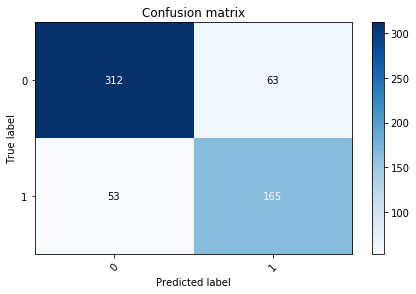

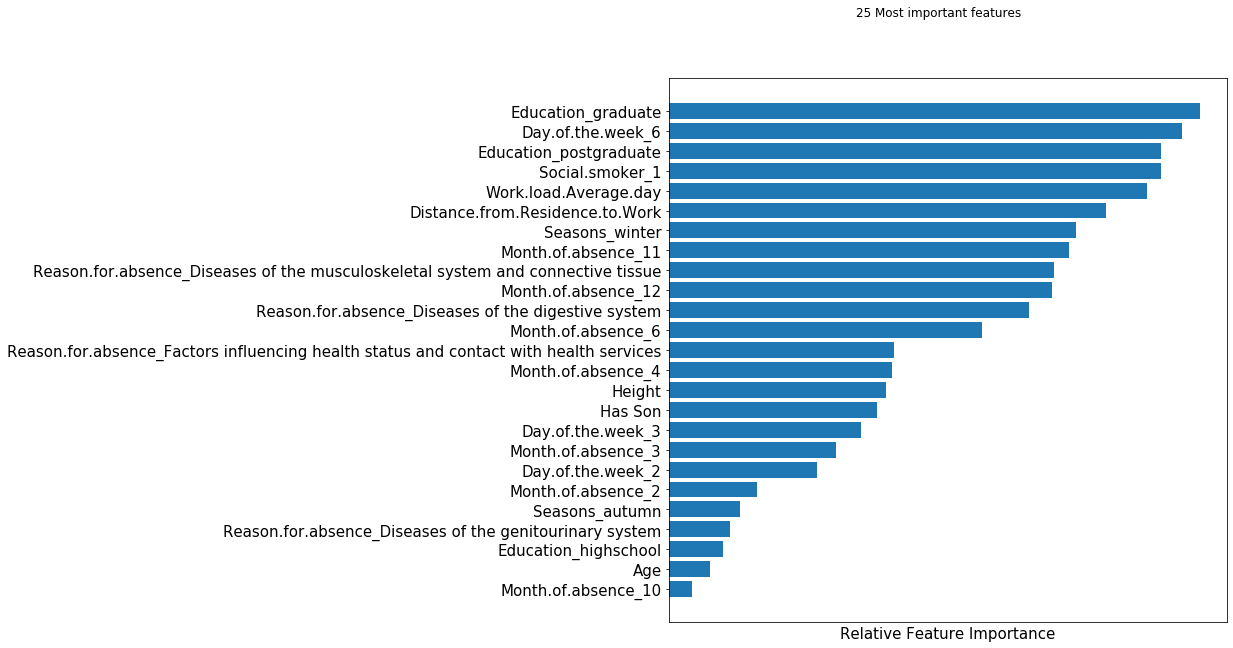

In [39]:
fe_4_model, score = train_model(fe_dataset.iloc[0:593].drop(['Absenteeism', 'Pet'],axis=1), fe_dataset.iloc[0:593]['Absenteeism'], linear_model.LogisticRegression(max_iter=10000, solver="lbfgs", penalty='none'))

In [40]:
results_df.loc[len(results_df)] = ['LR Feature Engineering 4', score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,LR without outliers,0.807322
2,LR without BMI,0.807757
3,LR without weight,0.809444
4,LR without Weight and Service Time,0.816189
5,LR without Weight and Age,0.811130
6,LR Feature Engineering 1,0.816189
7,LR Feature Engineering 2,0.821248
8,LR Feature Engineering 3,0.809444
9,LR Feature Engineering 4,0.804384


No improvement. It seems that the feature codifying the number of pets is the best way to include this information in the model.

In [41]:
fe_dataset = fe_dataset.drop(['Has Pet'], axis=1)

We have two features codifying the period of the year, the season and the month. They are more likely to have some impact in the absences. For example, there are sessional diseases like the flu, and periods in a year more prone to small absences. 


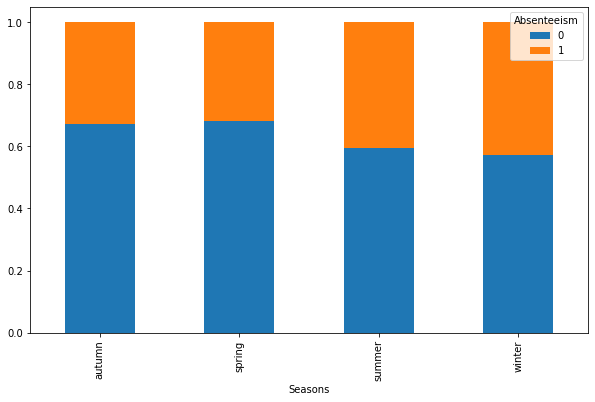

In [42]:
dataset.iloc[0:593].groupby(['Seasons'])['Absenteeism']\
    .value_counts(normalize=True)\
    .unstack(level=1)\
    .plot.bar(stacked=True,figsize=(10,6))

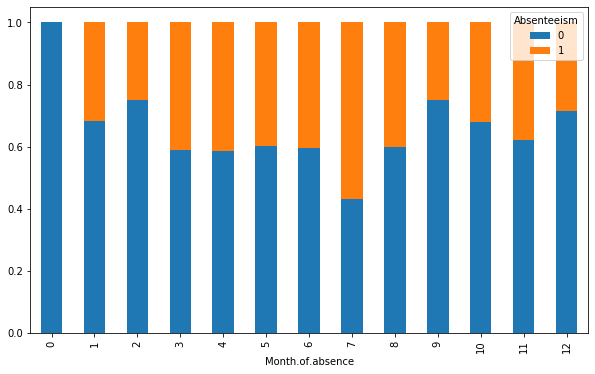

In [43]:
dataset.iloc[0:593].groupby(['Month.of.absence'])['Absenteeism']\
    .value_counts(normalize=True)\
    .unstack(level=1)\
    .plot.bar(stacked=True,figsize=(10,6))

It seems that both features offer some interesting information, so let's keep them both

Let's move to the feature selection phase

## Feature Selection

Even though this Dataset is not too extensive, it's always a good idea to apply some of the filtering methodologies seen in the Machine Learning II class to remove uninformative features.

### Filtering Methods
I will rank the features according to their predictive power: Chi Squared Independence test and Information Gain.


#### Chi-squared Selection
Measures the relationship between the features and the target feature, by using the chi squared selection. We keep those only 'representative enough'.

The following code computes the ChiSquared value for all the features. These values are then used to filter out the features with less importance according to the ChiSquared analysis. 

To automatize this process, I am removing all the features in which ChiSquared score is in the last quartile of the values.

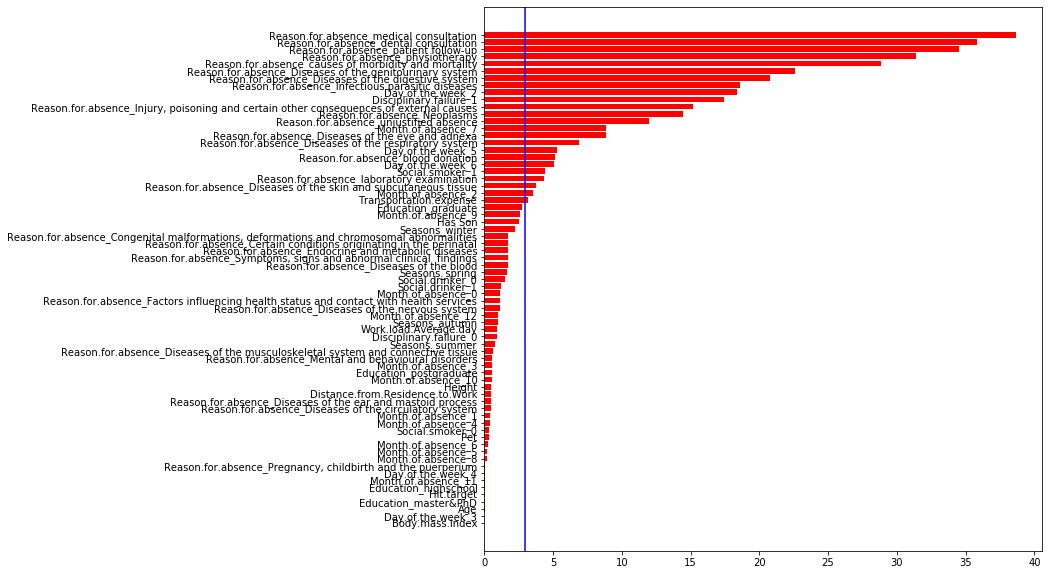

ChiSquared Threshold 2.9593563867325345


In [44]:
from sklearn.feature_selection import SelectKBest, chi2
from operator import itemgetter

chi2_selector = SelectKBest(score_func=chi2).fit(fe_dataset.iloc[0:593].drop(['Absenteeism'],axis=1), fe_dataset.iloc[0:593]['Absenteeism'])

# Get the indices sorted by most important to least important
indices = np.argsort(chi2_selector.scores_)[::-1]

chi2_features = defaultdict(float)
for i in range(len(fe_dataset.iloc[0:593].drop(['Absenteeism'],axis=1).columns)):
    chi2_features[fe_dataset.iloc[0:593].drop(['Absenteeism'],axis=1).columns[indices[i]]] += chi2_selector.scores_[indices[i]]
    
items = sorted(chi2_features.items(), key=itemgetter(1), reverse=True)
keys, values = list(zip(*items))

plt.figure(figsize=(10,10))
plt.yticks(list(range(len(keys))), keys, rotation=0, fontsize=10)
plt.barh(list(range(len(keys))), values, color='r', align='center')
chi2_th = pd.Series(list(chi2_features.values())).quantile(0.25)*6
plt.axvline(chi2_th, color='blue')
plt.gca().invert_yaxis()

plt.show()

print("ChiSquared Threshold", chi2_th)

As we do not need all of this apparatus to compute the threshold, I can use mostly 0s at threshold, and say that any feature with a Chi-Squared equal to 0 (i.e., not related to the target variable) is not relevant and, consequently, remove it.

Now, we can test if this a good move.


Features to remove = dict_keys(['Education_graduate', 'Month.of.absence_9', 'Has Son', 'Seasons_winter', 'Reason.for.absence_Congenital malformations, deformations and chromosomal abnormalities', 'Reason.for.absence_Certain conditions originating in the perinatal', 'Reason.for.absence_Endocrine and metabolic diseases', 'Reason.for.absence_Symptoms, signs and abnormal clinical  findings', 'Reason.for.absence_Diseases of the blood', 'Seasons_spring', 'Social.drinker_0', 'Social.drinker_1', 'Month.of.absence_0', 'Reason.for.absence_Factors influencing health status and contact with health services', 'Reason.for.absence_Diseases of the nervous system', 'Month.of.absence_12', 'Seasons_autumn', 'Work.load.Average.day', 'Disciplinary.failure_0', 'Seasons_summer', 'Reason.for.absence_Diseases of the musculoskeletal system and connective tissue', 'Reason.for.absence_Mental and behavioural disorders', 'Month.of.absence_3', 'Education_postgraduate', 'Month.of.absence_10', 'Height', 'Distance.from

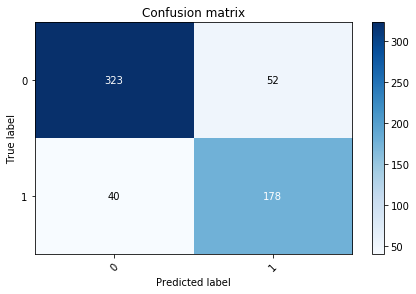

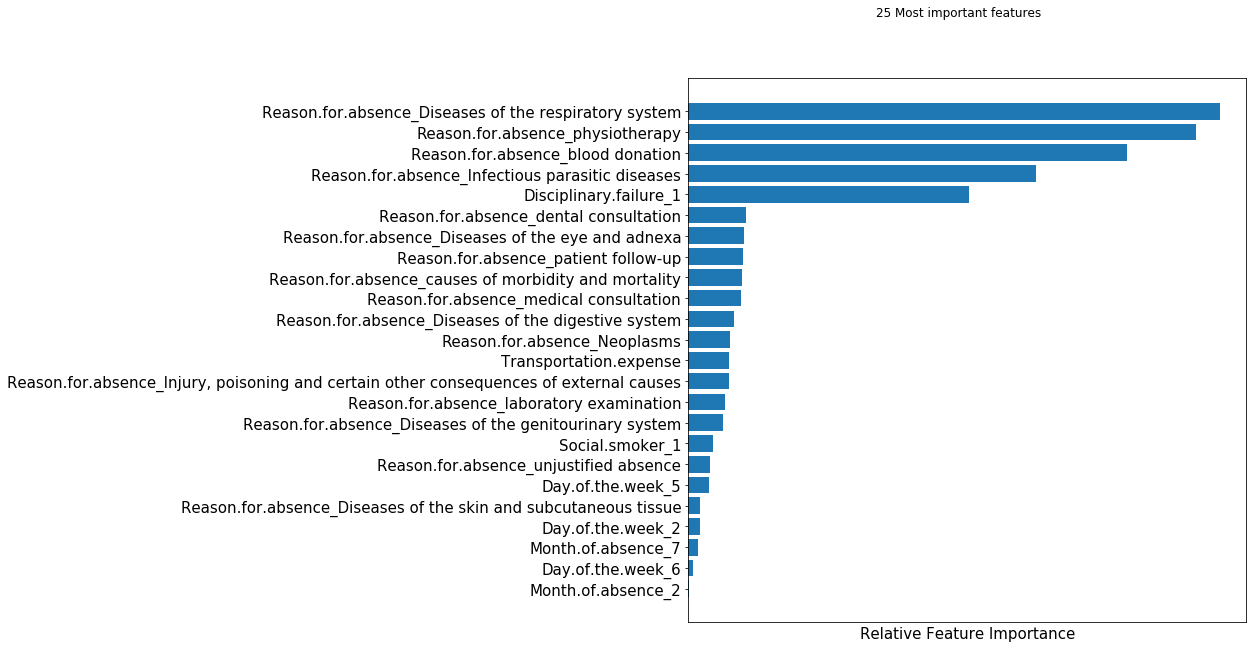

In [45]:
chi2_features_to_remove = dict(filter(lambda x: x[1] <= chi2_th, chi2_features.items())).keys()
print("Features to remove = {}".format(chi2_features_to_remove))
chi2_model, score = train_model(fe_dataset.iloc[0:593].drop(list(chi2_features_to_remove)+['Absenteeism'], axis=1), fe_dataset.iloc[0:593]['Absenteeism'], linear_model.LogisticRegression(max_iter=10000, solver="lbfgs", penalty='none'))

It seems that we have improved the accuracy by removing some less relevant features, while focusing on those that are. These features are mainly based on medical related issues. This makes sense: there are some medical problems related to long absences, which are repeated over time (i.e., they are related to chronic problems).
Some others like blood_donation or dental consultation are very common and also kind of suspicious.

We also see some other "sensible" features related to having a disciplinary failure in the expedient, if the employee is a smoker or the day and month in which the absence happens.

In [46]:
results_df.loc[len(results_df)] = ['LR Chi2 Selection', score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,LR without outliers,0.807322
2,LR without BMI,0.807757
3,LR without weight,0.809444
4,LR without Weight and Service Time,0.816189
5,LR without Weight and Age,0.811130
6,LR Feature Engineering 1,0.816189
7,LR Feature Engineering 2,0.821248
8,LR Feature Engineering 3,0.809444
9,LR Feature Engineering 4,0.804384



#### Information Gain Selection

Below I'm trying the Information Gain to compare both results:

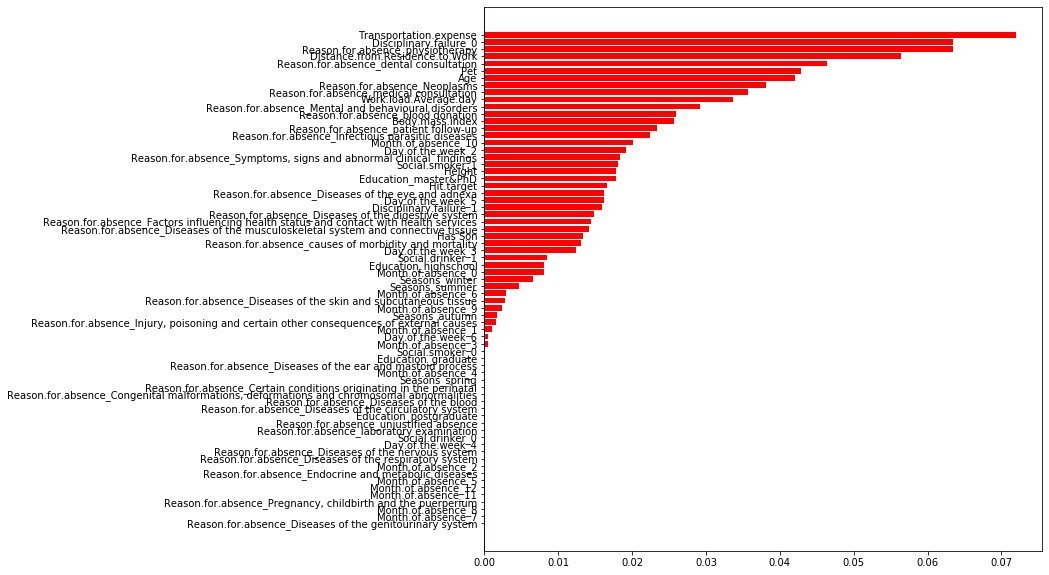

Information Gain Threshold 0.0


In [47]:
from sklearn.feature_selection import mutual_info_classif

ig_selector = SelectKBest(score_func=mutual_info_classif).fit(fe_dataset.iloc[0:593].drop(['Absenteeism'],axis=1), fe_dataset.iloc[0:593]['Absenteeism'])

# Get the indices sorted by most important to least important
indices = np.argsort(ig_selector.scores_)[::-1]

ig_features = defaultdict(float)
for i in range(len(fe_dataset.iloc[0:593].drop(['Absenteeism'],axis=1).columns)):
    ig_features[fe_dataset.iloc[0:593].drop(['Absenteeism'],axis=1).columns[indices[i]]] += ig_selector.scores_[indices[i]]
    
items = sorted(ig_features.items(), key=itemgetter(1), reverse=True)
keys, values = list(zip(*items))

plt.figure(figsize=(10,10))
plt.yticks(list(range(len(keys))), keys, rotation=0, fontsize=10)
plt.barh(list(range(len(keys))), values, color='r', align='center')
ig_th = pd.Series(list(ig_features.values())).quantile(0.25)*6
plt.axvline(ig_th, color='blue')
plt.gca().invert_yaxis()

plt.show()

print("Information Gain Threshold", ig_th)

Features to remove = dict_keys(['Social.smoker_0', 'Education_graduate', 'Reason.for.absence_Diseases of the ear and mastoid process', 'Month.of.absence_4', 'Seasons_spring', 'Reason.for.absence_Certain conditions originating in the perinatal', 'Reason.for.absence_Congenital malformations, deformations and chromosomal abnormalities', 'Reason.for.absence_Diseases of the blood', 'Reason.for.absence_Diseases of the circulatory system', 'Education_postgraduate', 'Reason.for.absence_unjustified absence', 'Reason.for.absence_laboratory examination', 'Social.drinker_0', 'Day.of.the.week_4', 'Reason.for.absence_Diseases of the nervous system', 'Reason.for.absence_Diseases of the respiratory system', 'Month.of.absence_2', 'Reason.for.absence_Endocrine and metabolic diseases', 'Month.of.absence_5', 'Month.of.absence_12', 'Month.of.absence_11', 'Reason.for.absence_Pregnancy, childbirth and the puerperium', 'Month.of.absence_8', 'Month.of.absence_7', 'Reason.for.absence_Diseases of the genitourina

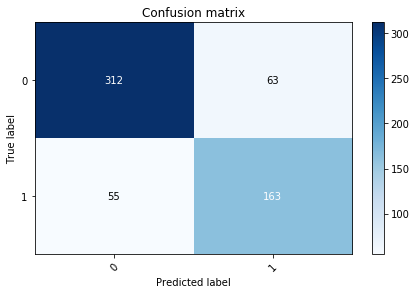

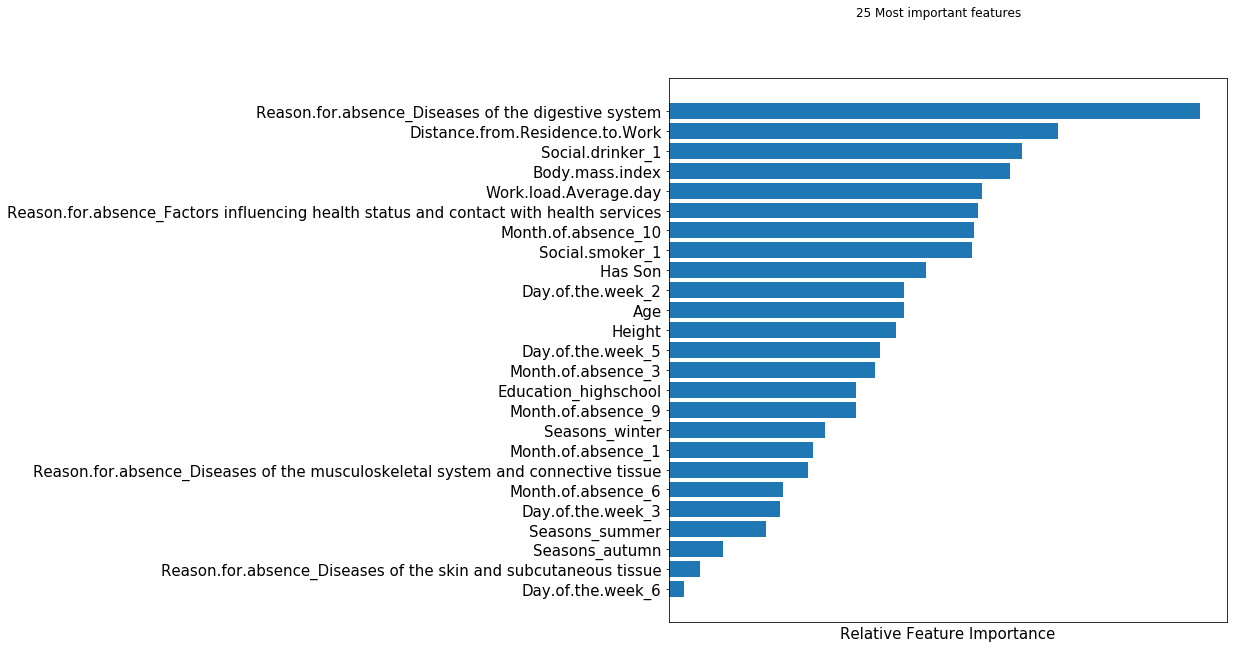

In [48]:
ig_features_to_remove = dict(filter(lambda x: x[1] <= ig_th, ig_features.items())).keys()
print("Features to remove = {}".format(ig_features_to_remove))
ig_model, score = train_model(fe_dataset.iloc[0:593].drop(list(ig_features_to_remove)+['Absenteeism'], axis=1), fe_dataset.iloc[0:593]['Absenteeism'], linear_model.LogisticRegression(max_iter=10000, solver="lbfgs", penalty='none'))

IG offers no performance enhancement. If we analyze the features, we clearly see many other features beyond the medical reason for the absence. It seems that IG is not able to capture the feature importance, up to the same degree of ChiSquared.

In [49]:
results_df.loc[len(results_df)] = ['LR IG', score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,LR without outliers,0.807322
2,LR without BMI,0.807757
3,LR without weight,0.809444
4,LR without Weight and Service Time,0.816189
5,LR without Weight and Age,0.811130
6,LR Feature Engineering 1,0.816189
7,LR Feature Engineering 2,0.821248
8,LR Feature Engineering 3,0.809444
9,LR Feature Engineering 4,0.804384


Let's remove the features that ChiSquared indicates

In [50]:
chi2_dataset = fe_dataset.drop(chi2_features_to_remove, axis=1)

### Embedded

Finally, I will apply embedded methods to create the final model. In my opinion, Logistic Regression models, properly regularized (with Lasso or Ridge), are going to perform better for this problem. We have a wide set of features that are not correlated among themselves. LR, in addition, is going to give me a clear interpretation of the model: the importance of the features is explained by means of the coefficients - learned by the model.
This will help us to later explain the model to the HR department, understanding better their own operation.

#### Ridge

For this exercise, I'm using Ridge Model in sklearn <https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification> to modify the training function `train_model`.


Firstly, I am going to update the training method to take the Ridge Model

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy = 0.8499


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


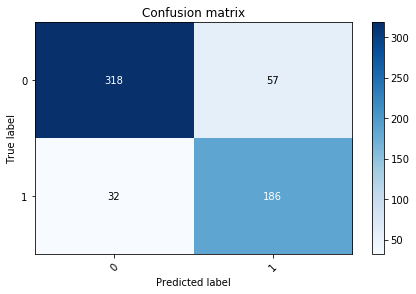

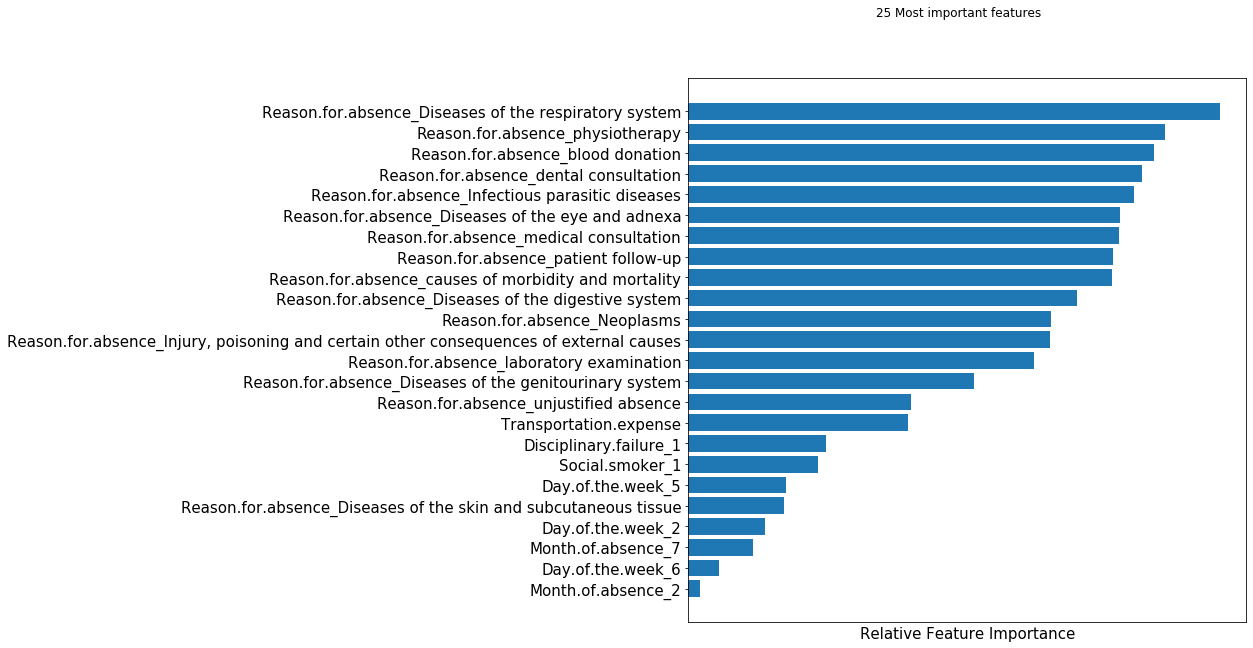

In [51]:
ridge_model,score = train_model(chi2_dataset.iloc[0:593].drop(['Absenteeism'], axis=1), chi2_dataset.iloc[0:593]['Absenteeism'], linear_model.RidgeClassifierCV(alphas=10**np.linspace(1,-4,100), cv=5))

In [52]:
results_df.loc[len(results_df)] = ['LR Ridge', score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,LR without outliers,0.807322
2,LR without BMI,0.807757
3,LR without weight,0.809444
4,LR without Weight and Service Time,0.816189
5,LR without Weight and Age,0.811130
6,LR Feature Engineering 1,0.816189
7,LR Feature Engineering 2,0.821248
8,LR Feature Engineering 3,0.809444
9,LR Feature Engineering 4,0.804384


The regularization provided by Ridge slightly improves the model accuracy. Beyond that, we should prefer regularized models as they are less likely to overfit, in the long run.

In addition, by taking a look to the feature importance we can see that the model is mainly focusing on the medical issues

Let's take a look at how the coefficient weights and accuracy scores change along the different alpha values.

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


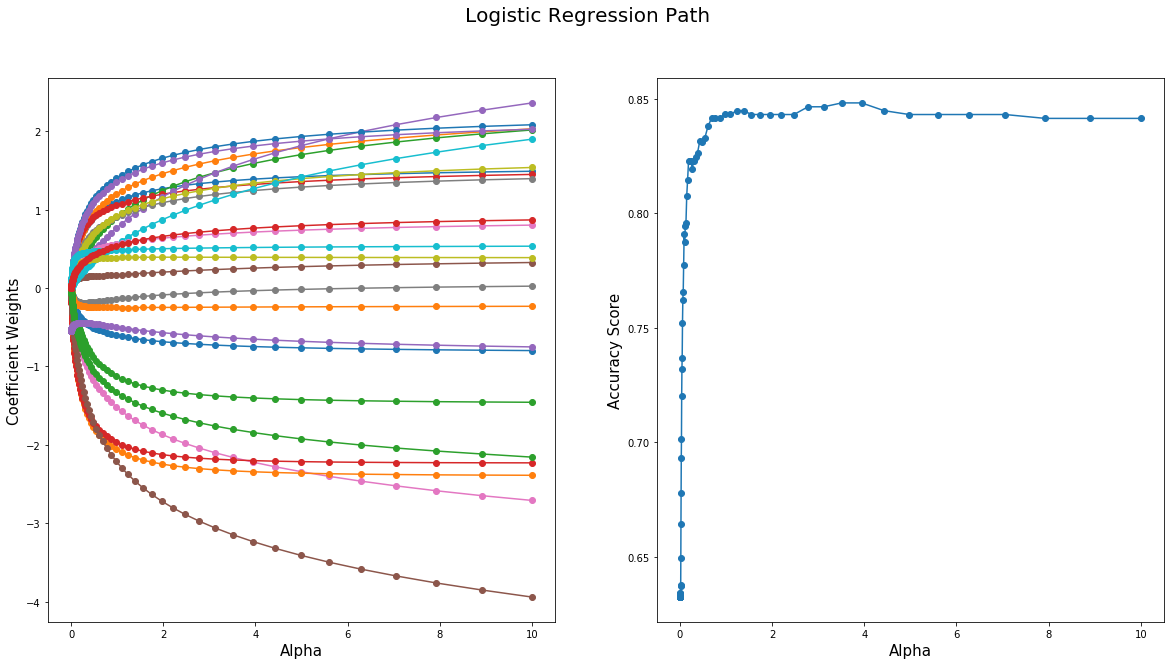

In [53]:
ridge_mod = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l2')
alphas = 10**np.linspace(1,-4,100)

coefs_ = []
scores_ = []
ridge_mod.set_params(Cs=alphas)
ridge_mod.fit(chi2_dataset.iloc[0:593].drop(['Absenteeism'],axis=1), chi2_dataset.iloc[0:593]['Absenteeism'])

coefs_ = np.mean(ridge_mod.coefs_paths_[1], axis=0)
scores_ = np.mean(ridge_mod.scores_[1], axis=0)
    
coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('Alpha', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('Alpha', fontsize = 15)
ax2.axis('tight')

plt.show()

#### Lasso

Now I will use the Lasso regularization to see if we get different results. To that end, I will again use sklearn to fit a cross-validated lasso model and analyze its results


Accuracy = 0.8449


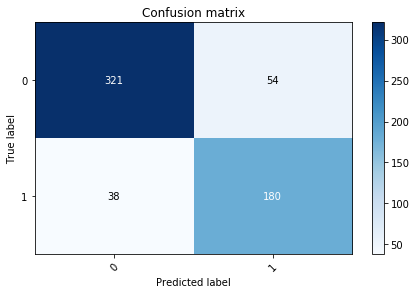

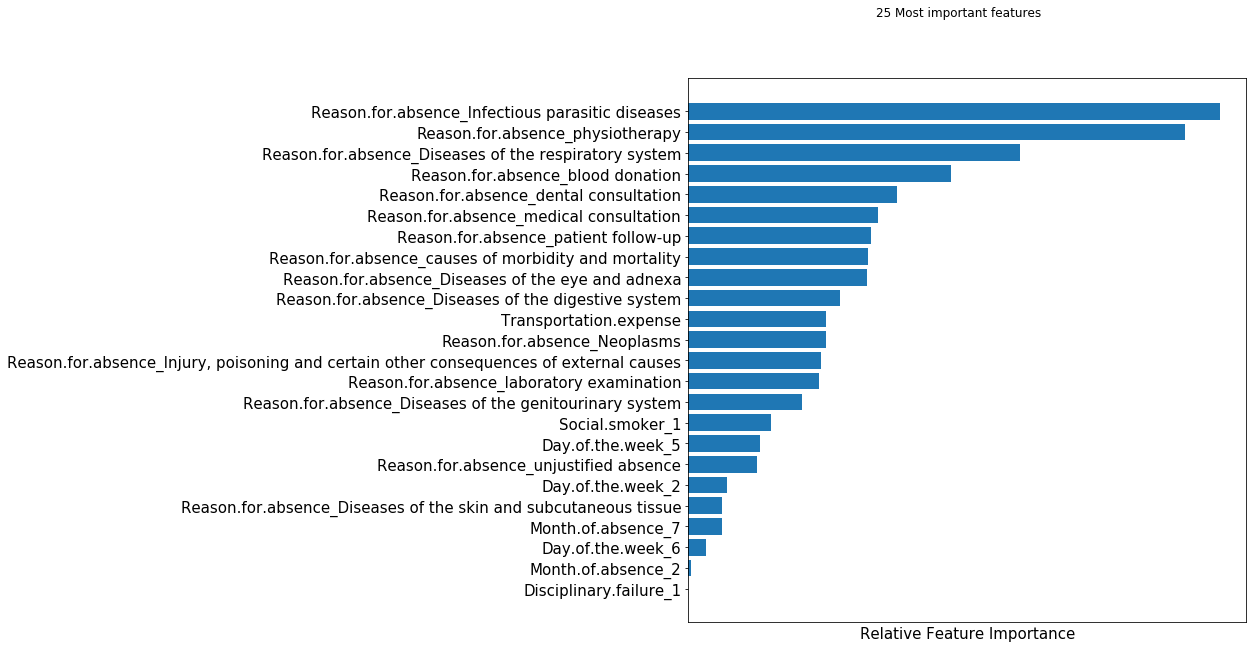

In [56]:
lasso_model, score = train_model(chi2_dataset.iloc[0:593].drop(['Absenteeism'], axis=1), chi2_dataset.iloc[0:593]['Absenteeism'], linear_model.LogisticRegressionCV(cv=5, penalty = 'l1', solver='liblinear', max_iter=10000, Cs = 10**np.linspace(1,-4,200)))

In [57]:
results_df.loc[len(results_df)] = ['LR Lasso', score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,LR without outliers,0.809249
2,LR without BMI,0.807757
3,LR without weight,0.809444
4,LR without Weight and Service Time,0.816189
5,LR without Weight and Age,0.811130
6,LR Feature Engineering 1,0.816189
7,LR Feature Engineering 2,0.821248
8,LR Feature Engineering 3,0.809444
9,LR Feature Engineering 4,0.804384


In [61]:
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(lasso_model, prefit=True)
X_new = model.transform(chi2_dataset.iloc[0:593].drop(['Absenteeism'], axis=1))
X_test_new = model.transform(chi2_dataset.iloc[593:len(chi2_dataset)].drop(['Absenteeism'], axis=1))
print("Original Number of Features = {} --> Number of features selected by Lasso = {}".format(chi2_dataset.iloc[0:593].drop(['Absenteeism'], axis=1).shape[1], X_new.shape[1]))

Original Number of Features = 24 --> Number of features selected by Lasso = 23


Lasso does not improve the final model beyond the accuracy provided by Ridge (as shown in the previous cell, Lasso is not actually removing any feature from the already cleaned dataset). Therefore, I will use Ridge as final model. 

With the following code you can inspect how the coefficients are affected by the Lasso Regularization

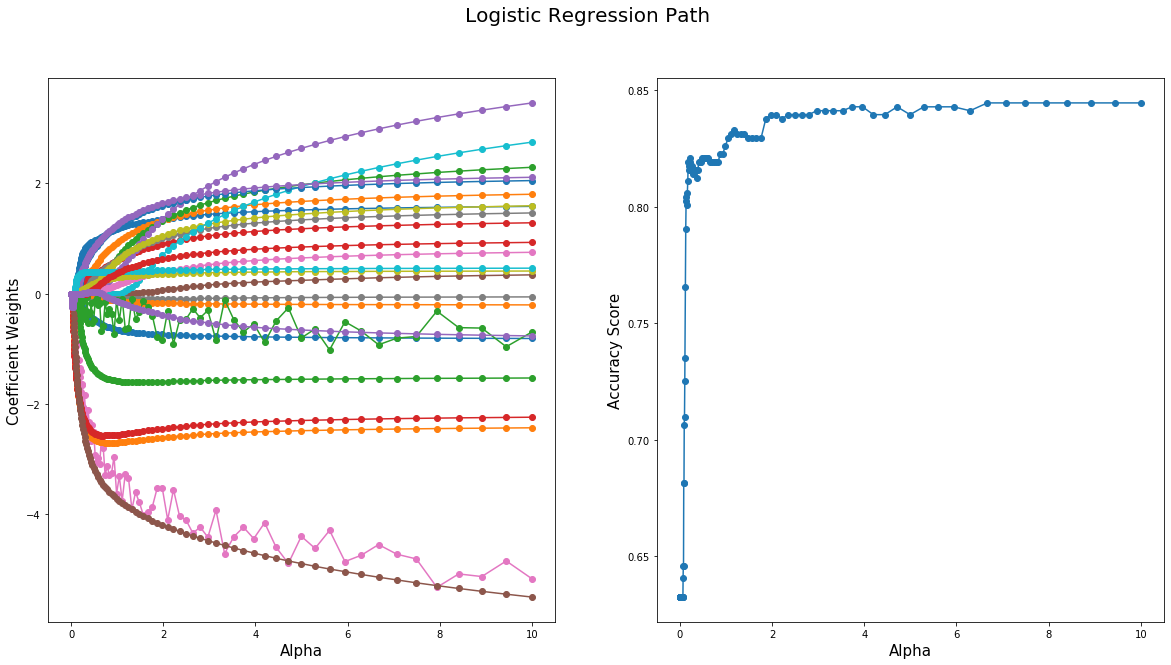

In [58]:
lasso_mod = linear_model.LogisticRegressionCV(cv=5, penalty = 'l1', solver='liblinear', max_iter=10000)
alphas = 10**np.linspace(1,-4,200)

coefs_ = []
scores_ = []
lasso_mod.set_params(Cs=alphas)
lasso_mod.fit(chi2_dataset.iloc[0:593].drop(['Absenteeism'],axis=1), chi2_dataset.iloc[0:593]['Absenteeism'])

coefs_ = np.mean(lasso_mod.coefs_paths_[1], axis=0)
scores_ = np.mean(lasso_mod.scores_[1], axis=0)
    
coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('Alpha', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('Alpha', fontsize = 15)
ax2.axis('tight')

plt.show()

By taking a look into feature importance, we see similar features to which which Ridge focuses. However, as shown in the figures above, the regularization performed by Lasso is way steeper than the one performed by Ridge. For this dataset it seems to be too much. So I prefer Ridge for creating the final model.



# Conclusions

In this section I'm summarizing the different insights and recommendations to HR, derived from this analysis.

- The first thing to remark is that we have a ML model that is able to predict whether a given employee is likely to have absences, or not, with an accuracy close to 85%. Although this is up to the HR department to decide whether they apply or not the model into production, my recommendation as an aspiring Data Scientist, is that the data model is good enough to be deployed into production.
- I did not implement any complex models (Random Forest or XGBoost), as this simple LR model is good enough to capture what makes an employee be absent. Therefore, no need for any other complex solutions.
- The most important causes for absences are medical-related absences. In this regard, we can mainly explain those as justified or "legit" absences. There are, nevertheless, some specific absences in which the HR department should investigate closely. Particularly absences related to blood donations, dental or medical consultations are sometimes proxies for just "wanting to rest at home for a "medical" reason".
- Other aspects that could be relevant for understanding the absences are actually not so important (e.g., Having children or pets, the age, ...) 

# Final Submission

The following piece of code takes your final model, creates the predictions for the test set and creates the submission file with the required format (a column with the `ID` and a column with the predictions `"Absenteeism`).

In [289]:
# Train the model using all the data
final_model = ridge_model

# Test prediction
final_pred = final_model.predict(chi2_dataset.iloc[593:len(chi2_dataset)].drop(['Absenteeism'],axis=1))
predictions = pd.DataFrame({'ID':test['ID'], 'Absenteeism.time.in.hours':final_pred})
predictions.to_csv("predictions.csv", index=False)